In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dunestyle.matplotlib as dunestyle
import time

DUNE plot style enabled


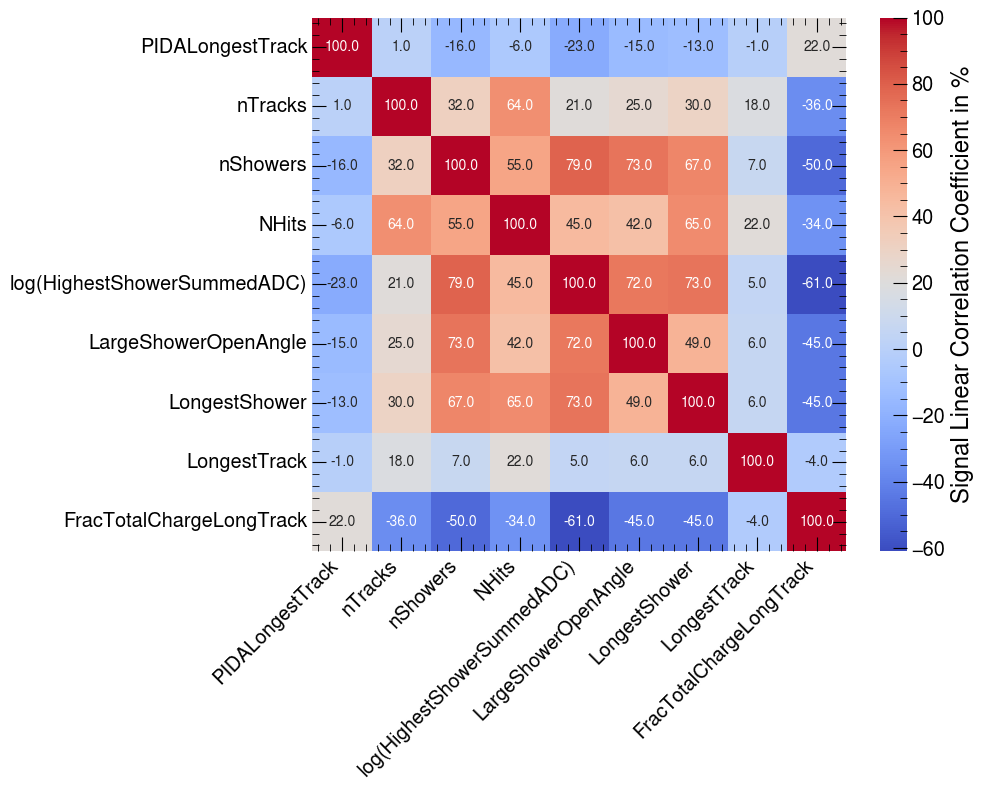

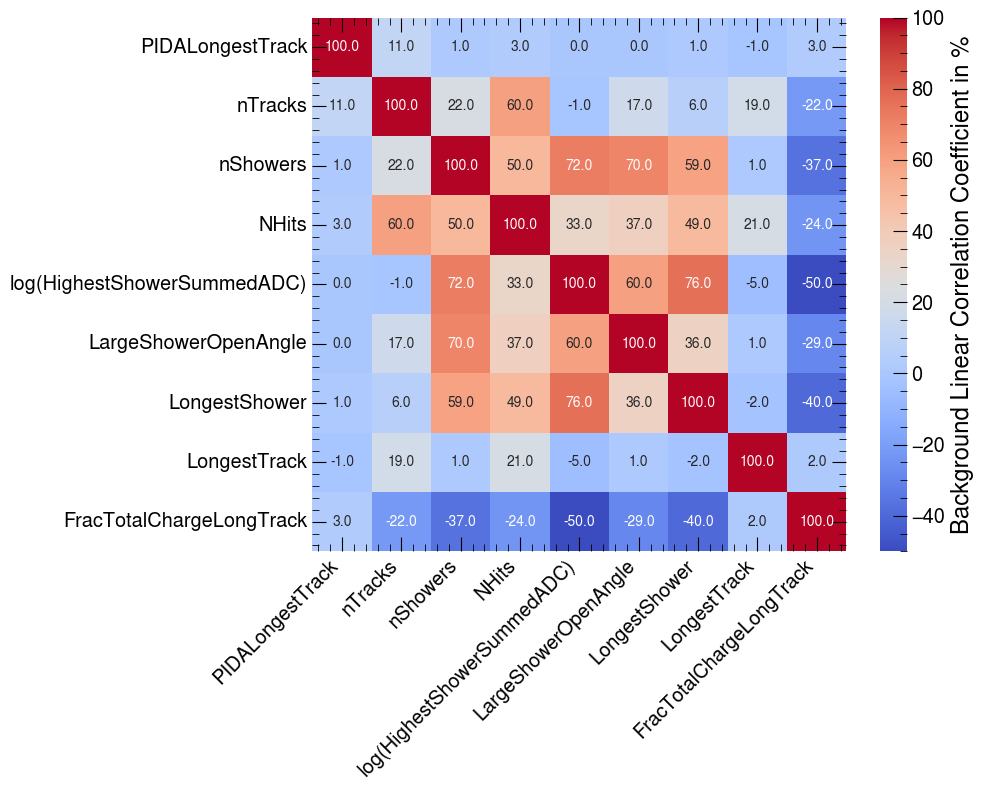

In [4]:
import seaborn as sns

# Define the variables names (CVN_NCScore removed)
variables = [
    "PIDALongestTrack", "nTracks", "nShowers", "NHits",
    "log(HighestShowerSummedADC)", "LargeShowerOpenAngle",
    "LongestShower", "LongestTrack", "FracTotalChargeLongTrack"
]

import numpy as np

correlation_matrix_background = np.array([
    [100,  11,   1,   3,   0,   0,   1,  -1,   3],
    [ 11, 100,  22,  60,  -1,  17,   6,  19, -22],
    [  1,  22, 100,  50,  72,  70,  59,   1, -37],
    [  3,  60,  50, 100,  33,  37,  49,  21, -24],
    [  0,  -1,  72,  33, 100,  60,  76,  -5, -50],
    [  0,  17,  70,  37,  60, 100,  36,   1, -29],
    [  1,   6,  59,  49,  76,  36, 100,  -2, -40],
    [ -1,  19,   1,  21,  -5,   1,  -2, 100,   2],
    [  3, -22, -37, -24, -50, -29, -40,   2, 100]
])

# Signal correlation matrix with CVN_NCScore row/col removed (now 9x9)
correlation_matrix_signal = np.array([
    [100,   1, -16,  -6, -23, -15, -13,  -1,  22],
    [  1, 100,  32,  64,  21,  25,  30,  18, -36],
    [-16,  32, 100,  55,  79,  73,  67,   7, -50],
    [ -6,  64,  55, 100,  45,  42,  65,  22, -34],
    [-23,  21,  79,  45, 100,  72,  73,   5, -61],
    [-15,  25,  73,  42,  72, 100,  49,   6, -45],
    [-13,  30,  67,  65,  73,  49, 100,   6, -45],
    [ -1,  18,   7,  22,   5,   6,   6, 100,  -4],
    [ 22, -36, -50, -34, -61, -45, -45,  -4, 100]
])

# Plotting function
def plot_correlation_matrix(corr_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="coolwarm", xticklabels=variables, yticklabels=variables,  cbar_kws={'label': title+' Linear Correlation Coefficient in %'})
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.yticks(rotation=0)  # Keep y-axis labels horizontal
    #plt.legend()
    #plt.title(title)
    plt.tight_layout()
    plt.savefig('bdt_corrMatrix_'+title+'_'+str(time.strftime("%Y%m%d"))+'.pdf', format='pdf')
    plt.show()

# Plot both matrices
plot_correlation_matrix(correlation_matrix_signal, "Signal")
plot_correlation_matrix(correlation_matrix_background, "Background")

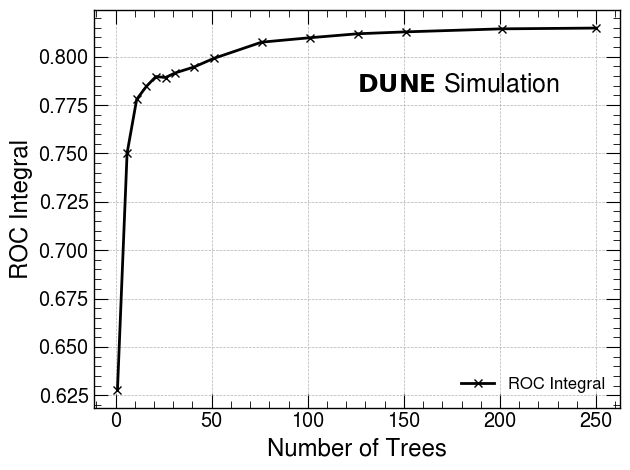

In [18]:
# ROC Integral vs iTree (from cv_BDTAtmCCNC_202601261224.C)
x_roc = np.array([1, 6, 11, 16, 21, 26, 31, 41, 51, 76, 101, 126, 151, 201, 250], dtype=float)
y_roc = np.array([0.6279331, 0.7501343, 0.7780058, 0.7846548, 0.7897817,
                  0.7892892, 0.7916504, 0.7947929, 0.7991422, 0.8075745,
                  0.8098543, 0.8119156, 0.8129001, 0.8144629, 0.8148599], dtype=float)

plt.figure()
plt.plot(x_roc, y_roc, marker='x', linestyle='-', label="ROC Integral")
plt.xlabel("Number of Trees")
plt.ylabel("ROC Integral")
plt.grid(True)
dunestyle.Simulation(0.5, 0.795)
plt.legend()
plt.tight_layout()
plt.savefig(f"bdt_rocint_{time.strftime('%Y%m%d')}.pdf", format="pdf")
plt.show()

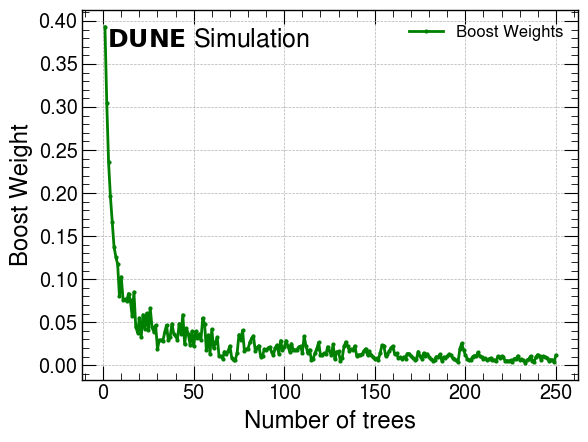

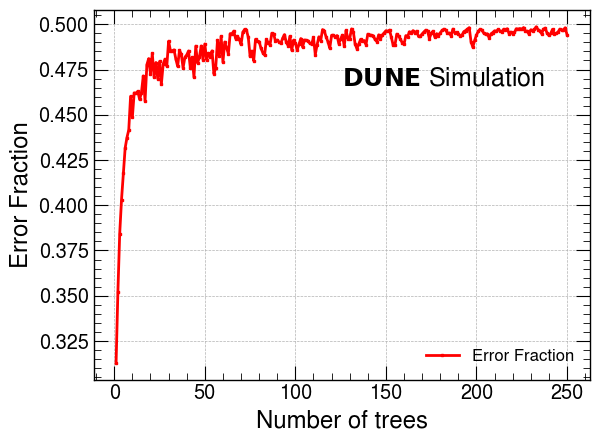

In [13]:
import re
import time
import numpy as np
import matplotlib.pyplot as plt


file_path = "cv_BDTAtmCCNC_202601261224.C"

# --- robust regex: works for BoostWeightVsTree__40, __43, etc. ---
re_boost = re.compile(r'BoostWeightVsTree__\d+->SetBinContent\(\s*(\d+)\s*,\s*([-\d.eE+]+)\s*\)')
re_err   = re.compile(r'ErrFractHist__\d+->SetBinContent\(\s*(\d+)\s*,\s*([-\d.eE+]+)\s*\)')


def parse_binned_series(path, pattern):
    """
    Returns a dense numpy array where index (bin-1) is the bin content.
    Handles out-of-order bins and different histogram suffixes (__40, __41, ...).
    """
    tmp = {}  # {bin_index_0based: value}
    with open(path, "r") as f:
        for line in f:
            m = pattern.search(line)
            if not m:
                continue
            b = int(m.group(1)) - 1  # ROOT bins are 1-based
            v = float(m.group(2))
            tmp[b] = v

    if not tmp:
        return np.array([], dtype=float)

    n = max(tmp.keys()) + 1
    arr = np.full(n, np.nan, dtype=float)
    for k, v in tmp.items():
        arr[k] = v
    return arr


boost_weights = parse_binned_series(file_path, re_boost)
error_fractions = parse_binned_series(file_path, re_err)

boost_x = np.arange(1, len(boost_weights) + 1)
err_x   = np.arange(1, len(error_fractions) + 1)

# If there are any missing bins (NaN), drop them safely
if boost_weights.size:
    mask = np.isfinite(boost_weights)
    boost_x = boost_x[mask]
    boost_weights = boost_weights[mask]

if error_fractions.size:
    mask = np.isfinite(error_fractions)
    err_x = err_x[mask]
    error_fractions = error_fractions[mask]


# -----------------
# Plot: Boost Weights vs Tree
# -----------------
plt.figure()
plt.plot(boost_x, boost_weights, marker="o", linestyle="-", color="g", markersize=2, label="Boost Weights")
plt.xlabel("Number of trees")
plt.ylabel("Boost Weight")
plt.grid(True)
dunestyle.Simulation()
plt.legend()
plt.savefig(f'bdt_boost_{time.strftime("%Y%m%d")}.pdf', format="pdf")
plt.show()


# -----------------
# Plot: Error Fraction vs Tree
# -----------------
plt.figure()
plt.plot(err_x, error_fractions, marker="s", linestyle="-", color="r", markersize=2, label="Error Fraction")
plt.xlabel("Number of trees")
plt.ylabel("Error Fraction")
plt.grid(True)
dunestyle.Simulation(0.5, 0.795)
plt.legend()
plt.savefig(f'bdt_error_{time.strftime("%Y%m%d")}.pdf', format="pdf")
plt.show()

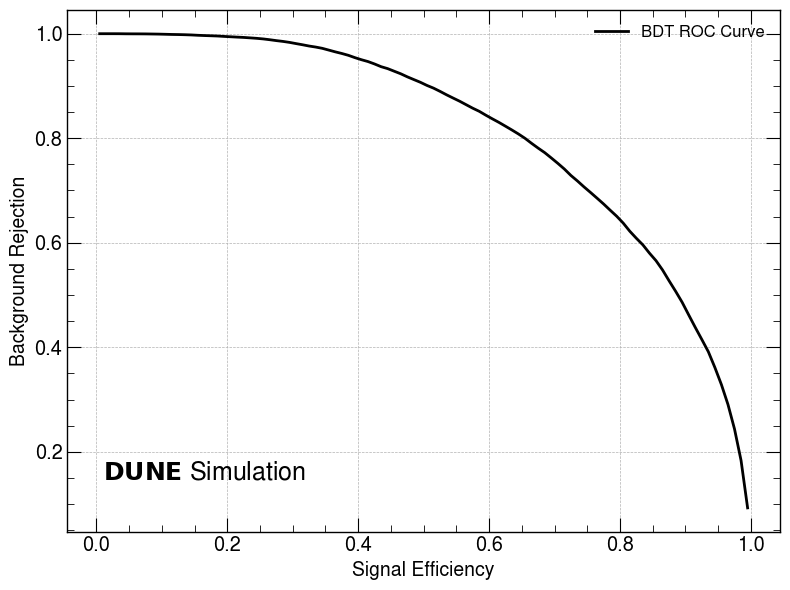

In [17]:
# ROOT histogram: TH1D(..., 100, 0, 1)  -> use bin centers
signal_efficiency = (np.arange(1, 101) - 0.5) / 100.0  # 0.005, 0.015, ..., 0.995

# Background rejection (1 - background efficiency), from SetBinContent(1..100, ...)
background_rejection = np.array([
    1, 1, 1, 0.9999613, 0.9998066, 0.9997292, 0.9996905, 0.9996132, 0.9994197, 0.9992263,
    0.9989168, 0.9985687, 0.9983752, 0.9980658, 0.9976402, 0.9969826, 0.9964797, 0.9960542, 0.9955899, 0.9948162,
    0.9941586, 0.9934812, 0.992882, 0.9920309, 0.9911412, 0.9899897, 0.988472, 0.9867653, 0.9852611, 0.9834043,
    0.9810832, 0.9788429, 0.9764207, 0.9744681, 0.9720569, 0.9686756, 0.9652641, 0.9621567, 0.9586503, 0.9541944,
    0.9502128, 0.9466968, 0.9420938, 0.9369079, 0.9332019, 0.9282361, 0.9233265, 0.9175155, 0.9122474, 0.9070627,
    0.9010723, 0.8959106, 0.8897044, 0.883095, 0.8769035, 0.8708213, 0.8641291, 0.8574695, 0.8514747, 0.8441039,
    0.8370941, 0.8303246, 0.8230405, 0.8156676, 0.8080259, 0.799729, 0.7901683, 0.7810653, 0.7724143, 0.7623197,
    0.7519656, 0.7411021, 0.7287966, 0.7182286, 0.7069279, 0.6962408, 0.6852646, 0.6741582, 0.6623092, 0.6507285,
    0.6375439, 0.6220526, 0.6086021, 0.5959234, 0.5801814, 0.5658041, 0.5479971, 0.5272655, 0.5071907, 0.4860908,
    0.4619598, 0.4381366, 0.4150416, 0.3915319, 0.3613626, 0.3285257, 0.2905594, 0.2435861, 0.1833969, 0.09274352
], dtype=float)

plt.figure(figsize=(8, 6))
plt.plot(signal_efficiency, background_rejection, linewidth=2, label="BDT ROC Curve")

plt.xlabel("Signal Efficiency", fontsize=14)
plt.ylabel("Background Rejection", fontsize=14)
plt.legend()
dunestyle.Simulation(0.05, 0.1)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"bdt_roc_{time.strftime('%Y%m%d')}.pdf", format="pdf")
plt.show()

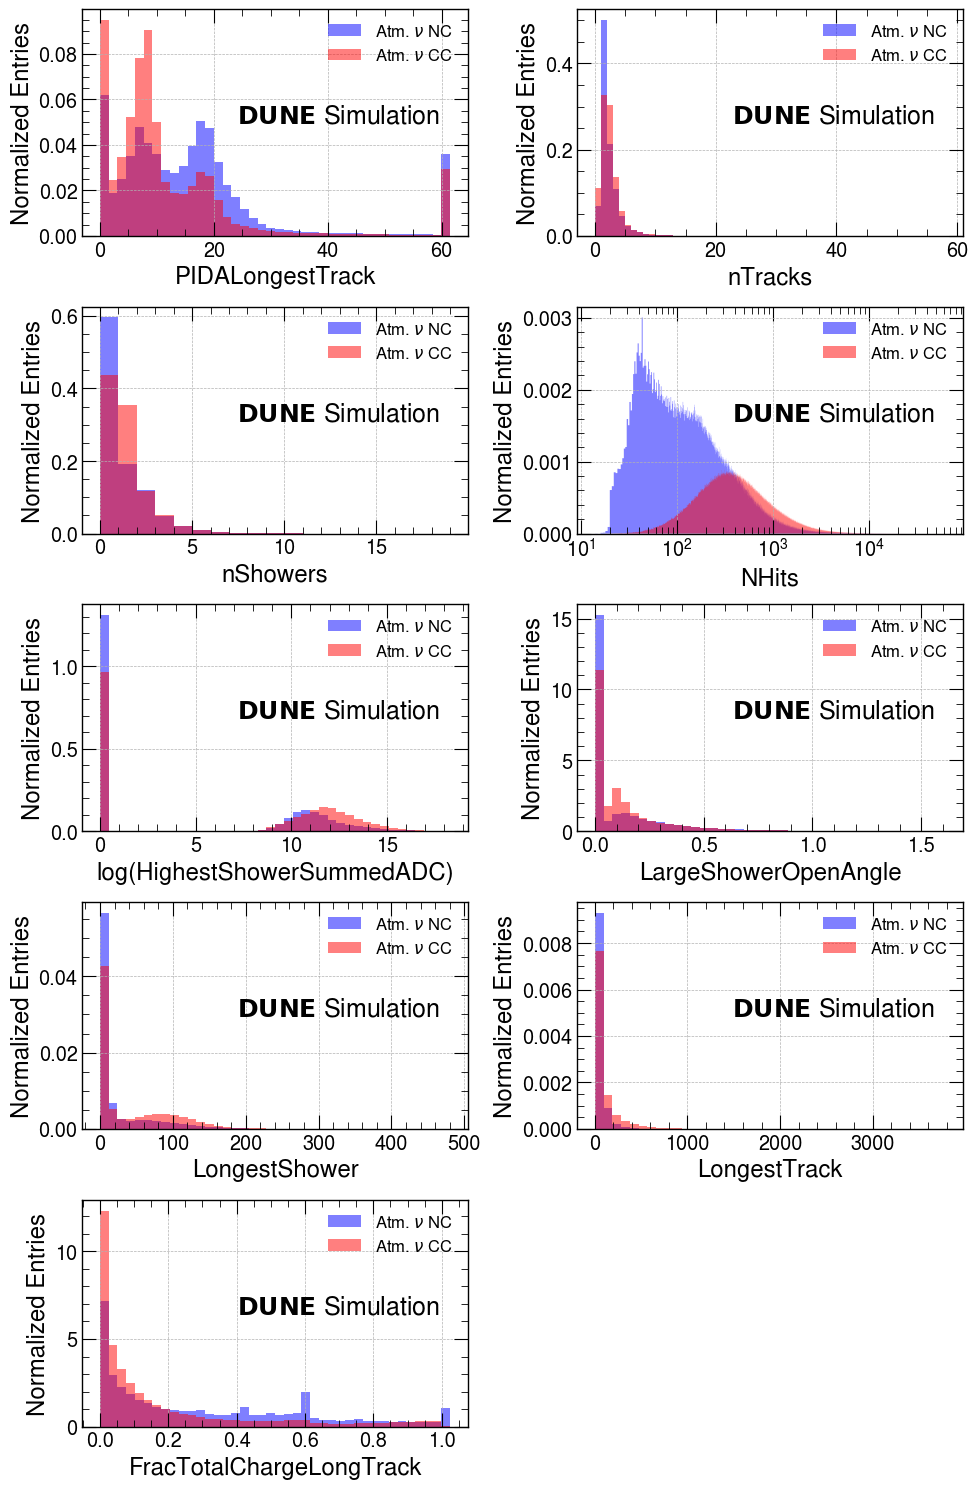

In [8]:
import re
import time
import numpy as np
import matplotlib.pyplot as plt

# Function to extract histograms from ROOT macro files
def extract_histogram_data(file_path):
    """
    Extract histogram data for signal and background from a ROOT macro file.

    Parameters:
    - file_path: Path to the ROOT macro file.

    Returns:
    - A dict: {hist_name: {variable, num_bins, x_min, x_max, bin_contents}}
    """
    histograms = {}
    current_hist = None

    # Regex patterns for histogram definitions and bin content
    hist_pattern = re.compile(
        r'TH1F\s*\*\s*([\w_]+)\s*=\s*new\s*TH1F\("([\w_]+)","([^"]+)",(\d+),([\d.eE+-]+),([\d.eE+-]+)\)'
    )
    bin_content_pattern = re.compile(r'SetBinContent\((\d+),([\d.eE+-]+)\)')

    with open(file_path, "r") as file:
        for line in file:
            # Histogram declaration
            hist_match = hist_pattern.search(line)
            if hist_match:
                hist_name = hist_match.group(1)
                variable_name = hist_match.group(3).replace("Input variable: ", "").strip()
                num_bins = int(hist_match.group(4))
                x_min = float(hist_match.group(5))
                x_max = float(hist_match.group(6))

                histograms[hist_name] = {
                    "variable": variable_name,
                    "num_bins": num_bins,
                    "x_min": x_min,
                    "x_max": x_max,
                    "bin_contents": np.zeros(num_bins, dtype=float),
                }
                current_hist = hist_name
                continue

            # Bin content assignments
            if current_hist:
                bin_match = bin_content_pattern.search(line)
                if bin_match:
                    bin_index = int(bin_match.group(1)) - 1  # ROOT bins are 1-based
                    value = float(bin_match.group(2))
                    nb = histograms[current_hist]["num_bins"]
                    if 0 <= bin_index < nb:
                        histograms[current_hist]["bin_contents"][bin_index] = value

    return histograms


# -----------------------------
# Read files and merge by variable
# -----------------------------
files_path = ["variables1.C", "variables2.C"]

variable_histograms = {}  # {variable: {"Signal": entry, "Background": entry}}

for file_path in files_path:
    hist_data = extract_histogram_data(file_path)

    for hist_name, entry in hist_data.items():
        var = entry["variable"]

        if var not in variable_histograms:
            variable_histograms[var] = {"Signal": None, "Background": None}

        if "Signal" in hist_name:
            variable_histograms[var]["Signal"] = entry
        elif "Background" in hist_name:
            variable_histograms[var]["Background"] = entry


# -----------------------------
# Make a grid with NO empty subplot
# -----------------------------
vars_in_order = list(variable_histograms.keys())  # preserves insertion order (py>=3.7)

nvars = len(vars_in_order)
ncols = 2
nrows = int(np.ceil(nvars / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3 * nrows))
axes = np.atleast_1d(axes).flatten()

i = 0
for var in vars_in_order:
    hist_dict = variable_histograms[var]
    signal_hist = hist_dict["Signal"]
    background_hist = hist_dict["Background"]

    if signal_hist is None and background_hist is None:
        continue

    ax = axes[i]

    # Define bins from whichever exists
    ref = signal_hist if signal_hist is not None else background_hist
    bins = np.linspace(ref["x_min"], ref["x_max"], ref["num_bins"] + 1)

    # Plot
    if signal_hist is not None:
        ax.hist(
            bins[:-1],
            bins,
            weights=signal_hist["bin_contents"],
            alpha=0.5,
            label=r"Atm. $\nu$ NC",
            color="b",
            histtype="stepfilled",
        )

    if background_hist is not None:
        ax.hist(
            bins[:-1],
            bins,
            weights=background_hist["bin_contents"],
            alpha=0.5,
            label=r"Atm. $\nu$ CC",
            color="r",
            histtype="stepfilled",
        )

    ax.set_xlabel(var)
    ax.set_ylabel("Normalized Entries")

    if var == "NHits":
        ax.set_xscale("log")

    dunestyle.Simulation(0.4, 0.5, ax=ax)
    ax.grid(True)
    ax.legend()

    i += 1

# delete any unused axes (prevents empty plot)
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f'bdt_inputs_{time.strftime("%Y%m%d")}.pdf', format='pdf')
plt.show()

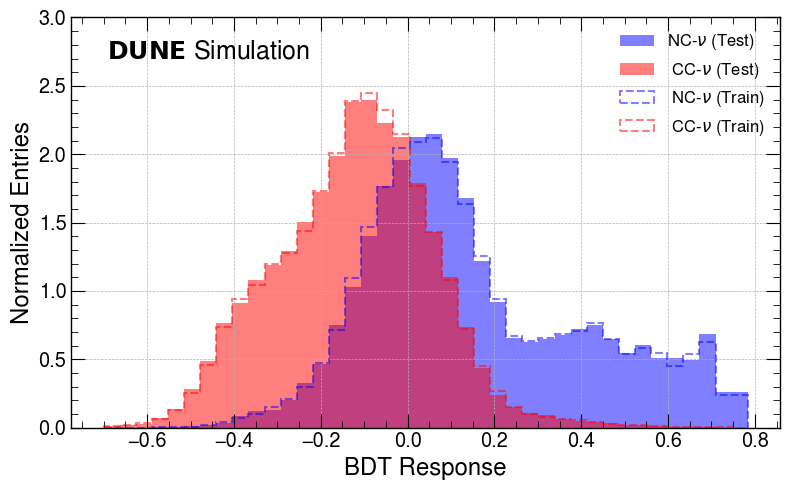

In [12]:
# Function to extract histogram data specifically from inputvariables1.C
def extract_histogram_data_overtraining(file_path):
    """
    Extracts histogram data for signal and background overtraining checks.

    Parameters:
    - file_path: Path to the ROOT macro file.

    Returns:
    - A dictionary containing histogram data for signal and background (train/test).
    """
    histograms = {}
    current_hist = None

    # Regex patterns to identify histograms and bin contents
    hist_pattern = re.compile(r'TH1D\s*\*\s*([\w_]+)\s*=\s*new\s*TH1D\("([\w_]+)","([^"]+)",(\d+),([\d.eE+-]+),([\d.eE+-]+)\)')
    bin_content_pattern = re.compile(r'SetBinContent\((\d+),([\d.eE+-]+)\)')

    with open(file_path, "r") as file:
        for line in file:
            # Check for histogram declaration
            hist_match = hist_pattern.search(line)
            if hist_match:
                hist_name = hist_match.group(1)
                num_bins = int(hist_match.group(4))
                x_min = float(hist_match.group(5))
                x_max = float(hist_match.group(6))

                histograms[hist_name] = {
                    "num_bins": num_bins,
                    "x_min": x_min,
                    "x_max": x_max,
                    "bin_contents": np.zeros(num_bins),
                }
                current_hist = hist_name

            # Check for bin content assignments
            if current_hist:
                bin_match = bin_content_pattern.search(line)
                if bin_match:
                    bin_index = int(bin_match.group(1)) - 1  # Convert ROOT 1-based to Python 0-based index
                    value = float(bin_match.group(2))

                    if 0 <= bin_index < histograms[current_hist]["num_bins"]:
                        histograms[current_hist]["bin_contents"][bin_index] = value

    return histograms

# Extract histograms from inputvariables1.C
hist_data_overtraining = extract_histogram_data_overtraining("response.C")

# Identify and categorize histograms
hist_signal_test = None
hist_signal_train = None
hist_background_test = None
hist_background_train = None

for hist_name, hist_data in hist_data_overtraining.items():
    if "Train_S" in hist_name:
        hist_signal_train = hist_data
    elif "Train_B" in hist_name:
        hist_background_train = hist_data
    elif "S__" in hist_name:  # Signal test histogram
        hist_signal_test = hist_data
    elif "B__" in hist_name:  # Background test histogram
        hist_background_test = hist_data

# Define bins (assuming all histograms share the same binning)
bins = np.linspace(hist_signal_test["x_min"], hist_signal_test["x_max"], hist_signal_test["num_bins"] + 1)

# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(bins[:-1], bins, weights=hist_signal_test["bin_contents"], alpha=0.5, label=rf"NC-$\nu$ (Test)", color="b", histtype='stepfilled')
plt.hist(bins[:-1], bins, weights=hist_background_test["bin_contents"], alpha=0.5, label=rf" CC-$\nu$ (Test)", color="r", histtype='stepfilled')
plt.hist(bins[:-1], bins, weights=hist_signal_train["bin_contents"], alpha=0.5, label=rf" NC-$\nu$ (Train)", color="b", linestyle="dashed", histtype='step')
plt.hist(bins[:-1], bins, weights=hist_background_train["bin_contents"], alpha=0.5, label=rf" CC-$\nu$ (Train)", color="r", linestyle="dashed", histtype='step')

plt.xlabel("BDT Response")
plt.ylabel("Normalized Entries")
#plt.title("Overtraining Check: Signal vs Background")
dunestyle.Simulation()
plt.ylim([0,3])
plt.legend(loc = 'upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('bdt_response_'+str(time.strftime("%Y%m%d"))+'.pdf', format='pdf')
plt.show()